# Protein → Orbifold Sonification (Diverse Mapping Edition)
**Features**: torsion‑angle mapping, secondary‑structure modal scales, RMSD‑driven rhythm, dynamic velocities, side‑chain overlay, 3‑octave chords, self‑tonic transpose, inline playback, rich plots.

## 0  Install (run once)

In [1]:
!pip install -q biopython music21 requests matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.9 MB/s eta 0:00:00


## 1  Imports

In [11]:
import numpy as np, os, requests, random, math
from Bio.PDB import PDBParser
from music21 import stream, chord, note, midi, pitch, converter, instrument, volume
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import itertools
print('Libraries ready ✔')

Libraries ready ✔


## 2  Pick and download a PDB

In [15]:
PDB_ID = '1PGB'  # 🔁 change me

def download_pdb(pdb_id, out_dir='pdb_files'):
    pdb_id = pdb_id.lower()
    os.makedirs(out_dir, exist_ok=True)
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    path = os.path.join(out_dir, f'{pdb_id}.pdb')
    if not os.path.exists(path):
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        with open(path, 'wb') as f:
            f.write(r.content)
        print('Downloaded', path)
    else:
        print('Using cached', path)
    return path

pdb_path = download_pdb(PDB_ID)

Downloaded pdb_files/1pgb.pdb


## 3  Parameters

In [4]:
WINDOW   = 5      # residues per chord
STRIDE   = 1
SPAN     = 3      # octaves
BASE_MID = 48     # C3
QL_BASE  = 0.5    # base quarterLength to scale by RMSD
TARGET_TONIC = 60 # centre on C4
GEN_LEN  = 150
SR       = 44100
print('Parameters set.')

Parameters set.


## 4  Core helper functions

In [16]:

# ============ Geometry helpers ============
def torsion(a, b, c, d):
    b1 = b - a
    b2 = c - b
    b3 = d - c
    n1 = np.cross(b1, b2)
    n2 = np.cross(b2, b3)
    x = np.dot(n1, n2)
    y = np.dot(np.cross(n1, n2), b2/np.linalg.norm(b2))
    return np.degrees(np.arctan2(y, x))  # -180..180

def extract_coords_and_torsions(pdb_file):
    """
    Returns
    -------
    coords : (N,3) ndarray   – all C-α coordinates
    phi    : length-N array  – φ torsion in degrees; NaN where undefined
    psi    : length-N array  – ψ torsion in degrees; NaN where undefined
    """
    parser  = PDBParser(QUIET=True)
    atoms   = [a for a in parser.get_structure('prot', pdb_file).get_atoms()
               if a.id == 'CA']
    coords  = np.array([a.get_coord() for a in atoms])
    N       = len(coords)

    # need at least 4 residues to define torsion
    if N < 4:
        raise ValueError("Protein too short for torsion calculation")

    phi = np.full(N, np.nan)
    psi = np.full(N, np.nan)

    # iterate only up to N-3 (exclusive) so i+3 is in-bounds
    for i in range(1, N - 3):
        phi[i] = torsion(coords[i-1], coords[i],
                         coords[i+1], coords[i+2])
        psi[i] = torsion(coords[i],   coords[i+1],
                         coords[i+2], coords[i+3])

    return coords, phi, psi

def classify_sec(phi, psi):
    if np.isnan(phi) or np.isnan(psi):
        return 'C'
    if -160 < phi < -30 and -80 < psi < 0:
        return 'H'   # helix
    if -180 < phi < -50 and 90 < psi < 180:
        return 'E'   # sheet
    return 'C'       # coil

ALPHA_SCALE = [0,2,4,5,7,9,11]
BETA_SCALE  = [0,3,5,7,10]
CHROM_SCALE = list(range(12))

def quantise(pc, scale):
    return min(scale, key=lambda x: min((pc-x)%12, (x-pc)%12))

def window_to_chord(start_idx, phi, psi):
    pcs = []
    scale_counts = {'H':0,'E':0,'C':0}
    for offset in range(WINDOW):
        idx = start_idx+offset
        angle = phi[idx] if idx < len(phi) else np.nan
        # if nan choose random angle
        if np.isnan(angle): angle = 0
        val = int(round(((angle+180)/(360))*(12*SPAN-1)))
        midi_raw = BASE_MID + val
        pcs.append(midi_raw)
        # secstruct for this residue
        sclass = classify_sec(phi[idx] if idx<len(phi) else np.nan, psi[idx] if idx<len(psi) else np.nan)
        scale_counts[sclass]+=1
    # choose majority scale
    scale = CHROM_SCALE
    if scale_counts['H']>scale_counts['E'] and scale_counts['H']>scale_counts['C']: scale=ALPHA_SCALE
    elif scale_counts['E']>scale_counts['H'] and scale_counts['E']>scale_counts['C']: scale=BETA_SCALE
    pcs_quant = []
    for m in pcs:
        octave = (m - BASE_MID)//12
        pc = m%12
        pc_q = quantise(pc, scale)
        pcs_quant.append(BASE_MID + 12*octave + pc_q)
    pcs_quant.sort()
    return tuple(pcs_quant)

def progression(coords, phi, psi):
    chords=[]
    for i in range(0, len(coords)-WINDOW+1, STRIDE):
        chords.append( window_to_chord(i, phi, psi) )
    return chords

def transpose_to_tonic(prog, target=TARGET_TONIC):
    root = int(np.median(prog[0]))
    shift=target-root
    return [tuple(n+shift for n in ch) for ch in prog]

def rmsd(a, b):
    return np.sqrt(np.mean(np.sum((a-b)**2, axis=1)))

def vl_distance(a,b):
    a_pc=[n%12 for n in a]; b_pc=[n%12 for n in b]
    best=1e9
    for perm in itertools.permutations(b_pc):
        best=min(best, sum(min(abs(x-y)%12,12-abs(x-y)%12) for x,y in zip(a_pc,perm)))
    return best

def build_tempi(coords):
    rms=[]
    for i in range(len(coords)-WINDOW):
        rms.append(rmsd(coords[i:i+WINDOW], coords[i+1:i+WINDOW+1]))
    rms=[rms[0]]+rms
    # map to note length 0.125-1.0
    ln = np.interp(rms, (min(rms), max(rms)), (0.125, 1.0))
    return ln

SIDE_VOL = {'ALA':3,'VAL':5,'ILE':5,'LEU':4,'PHE':7,'TYR':7,'TRP':9,'MET':5,'CYS':4,'GLY':1,
            'PRO':3,'SER':2,'THR':2,'ASP':4,'GLU':5,'ASN':4,'GLN':5,'HIS':6,'LYS':5,'ARG':7}

def side_chain_line(structure):
    volumes=[]
    for r in structure.get_residues():
        name=r.get_resname()
        volumes.append(SIDE_VOL.get(name.strip(),3))
    midi=[BASE_MID+24+v for v in volumes]  # octave above chords
    return midi


## 5  Build streams & MIDI export

In [17]:

# extract geometry
coords, phi, psi = extract_coords_and_torsions(pdb_path)
parser = PDBParser(QUIET=True)
structure = parser.get_structure('prot', pdb_path)

orig_prog = transpose_to_tonic( progression(coords, phi, psi) )
print('Original progression:', len(orig_prog))

# Markov grammar
def train_model(seq):
    from collections import defaultdict, Counter
    model=defaultdict(Counter)
    for i in range(len(seq)-1):
        model[seq[i]][seq[i+1]]+=1
    return {s:{k:v/sum(d.values()) for k,v in d.items()} for s,d in model.items()}

model = train_model(orig_prog)
gen_prog=[orig_prog[0]]
while len(gen_prog)<GEN_LEN:
    state=gen_prog[-1]
    if state not in model: break
    choices,weights=zip(*model[state].items())
    gen_prog.append(random.choices(choices,weights)[0])
print('Generated progression:', len(gen_prog))

# dynamics from VL
vl=[vl_distance(orig_prog[i], orig_prog[i+1]) for i in range(len(orig_prog)-1)]
vl=[vl[0]]+vl
vel=[20+(d/max(vl))*100 for d in vl]

# rhythm from RMSD
lengths=build_tempi(coords)[:len(orig_prog)]

# build chord stream
def seq_to_stream(seq, lengths=None, velocities=None):
    s=stream.Stream()
    for i,chd in enumerate(seq):
        ql=lengths[i] if lengths is not None else QL_BASE
        c=chord.Chord([pitch.Pitch(n) for n in chd], quarterLength=float(ql))
        if velocities: c.volume.velocity=int(velocities[i])
        s.append(c)
    return s

orig_stream = seq_to_stream(orig_prog, lengths, vel)
gen_stream  = seq_to_stream(gen_prog)

# side-chain overlay
side_notes = side_chain_line(structure)
side_part = stream.Part()
for n in side_notes:
    side_part.append(note.Note(n, quarterLength=0.125, volume=volume.Volume(velocity=80), instrument=instrument.Flute()))

full_stream = stream.Stream([orig_stream, side_part])

# save
def save_mid(s, name):
    mf=midi.translate.streamToMidiFile(s); mf.open(name,'wb'); mf.write(); mf.close(); print('Saved',name)

save_mid(orig_stream,'protein_original.mid')
save_mid(gen_stream,'protein_generated.mid')
save_mid(full_stream,'protein_duo.mid')


Original progression: 52
Generated progression: 54
Saved protein_original.mid
Saved protein_generated.mid
Saved protein_duo.mid


## 6  Inline playback

In [18]:

from music21 import environment
environment.set('musicxmlPath', '/usr/bin/true')  # disable musicxml open

def show_midi(fname):
    return converter.parse(fname).show('midi')

show_midi('protein_original.mid')
show_midi('protein_generated.mid')
show_midi('protein_duo.mid')


## 7  Visual analysis

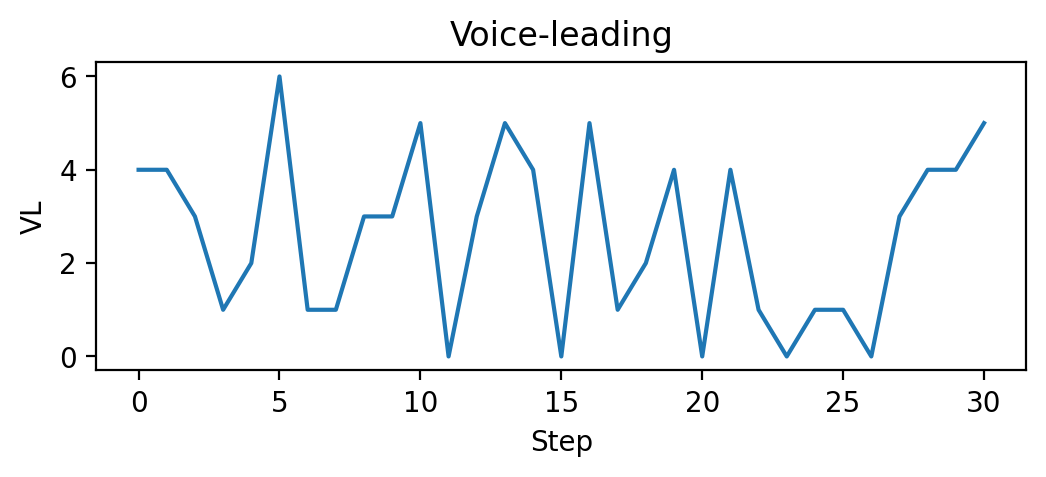

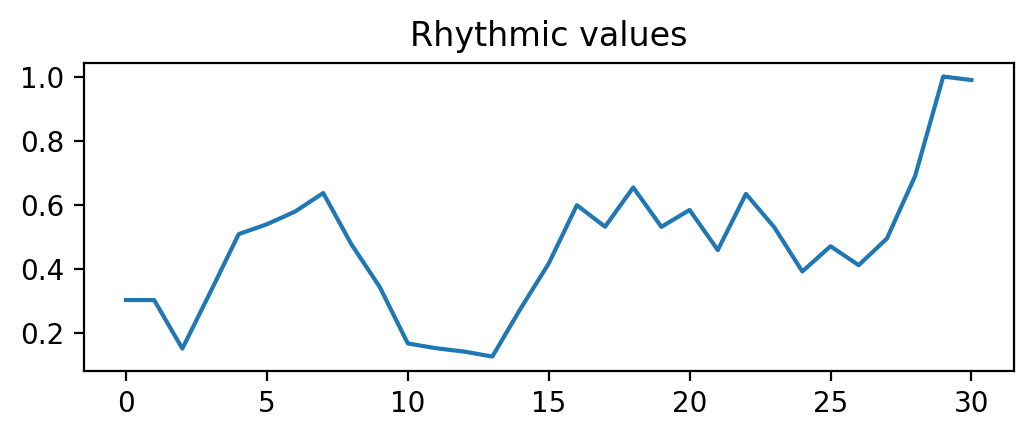

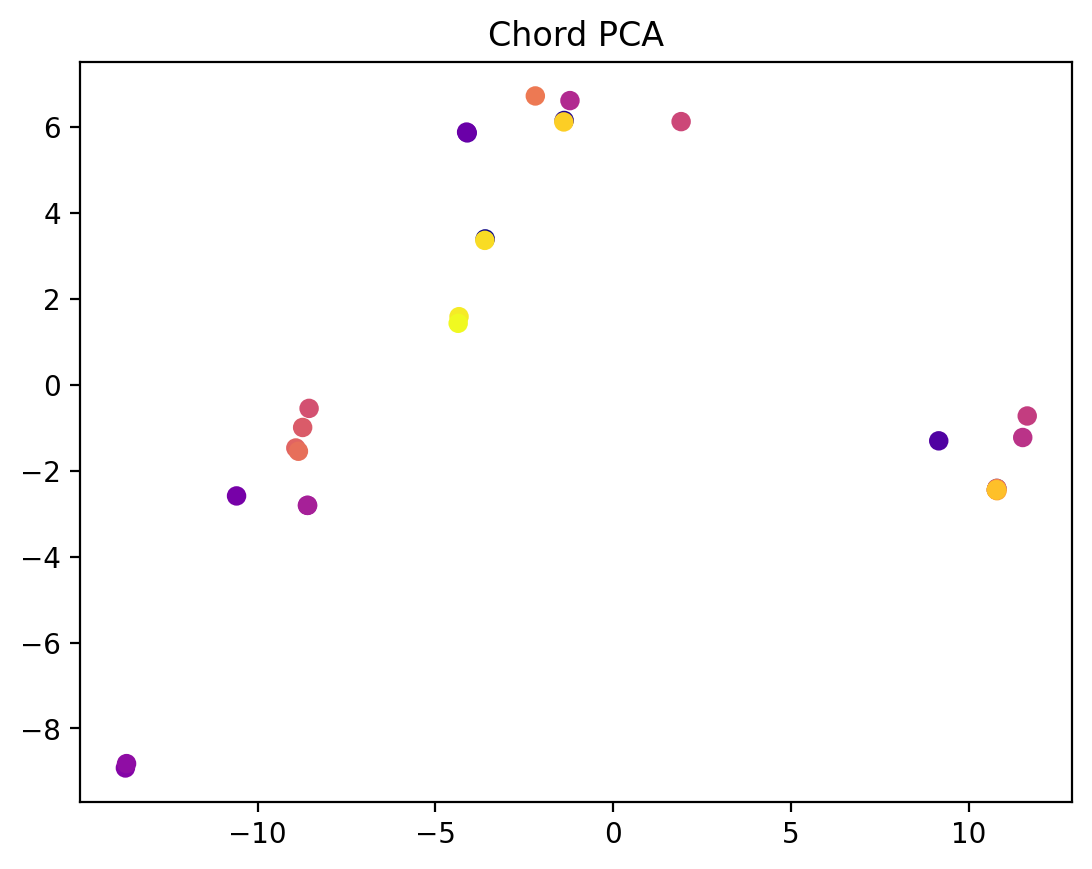

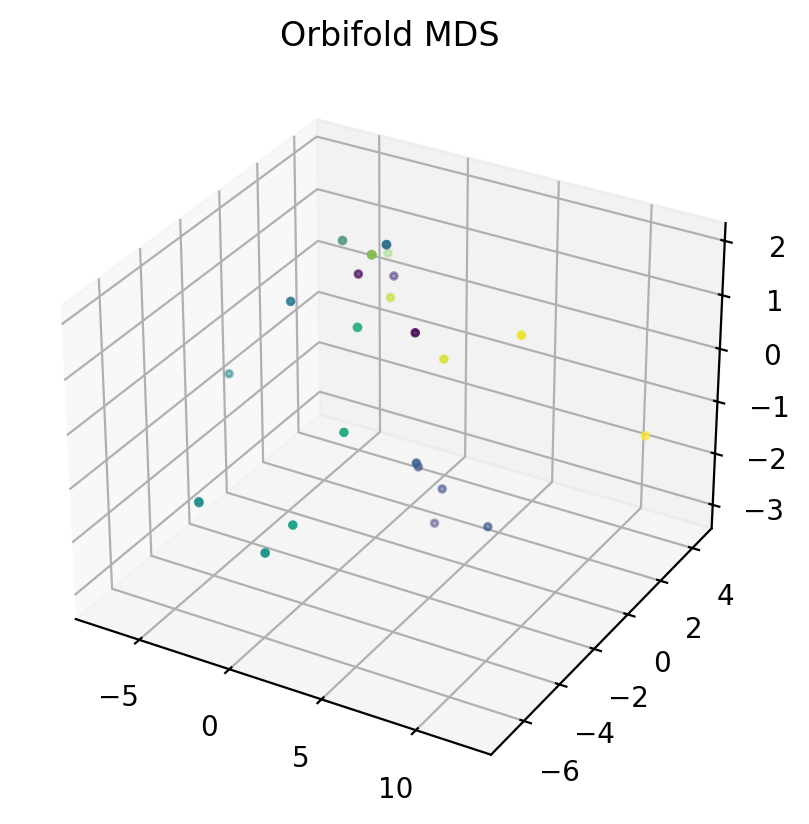

In [14]:

# VL plot
plt.figure(figsize=(6,2))
plt.plot(vl); plt.title('Voice-leading'); plt.xlabel('Step'); plt.ylabel('VL'); plt.show()

# Tempo lengths
plt.figure(figsize=(6,2))
plt.plot(lengths); plt.title('Rhythmic values'); plt.show()

# PCA of chords
mat=np.array(orig_prog)
xy=PCA(2).fit_transform(mat)
plt.figure(); plt.scatter(xy[:,0], xy[:,1], c=np.arange(len(xy)), cmap='plasma'); plt.title('Chord PCA'); plt.show()

# Orbifold MDS
n=len(orig_prog); D=np.zeros((n,n))
for i in range(n):
    for j in range(i+1,n):
        D[i,j]=D[j,i]=vl_distance(orig_prog[i], orig_prog[j])
xyz=MDS(3,dissimilarity='precomputed',random_state=0).fit_transform(D)
fig=plt.figure(); ax=fig.add_subplot(111,projection='3d')
p=ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],c=np.arange(n), cmap='viridis', s=6)
ax.set_title('Orbifold MDS'); plt.show()
